## Data generator

In [ ]:
# we import some libraries that will be used during the project
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import matplotlib functionality 
from matplotlib import gridspec, patches
from matplotlib.colors import ListedColormap

In [ ]:
# number of dataset images 
n_imgs = 10000

# images side dimension
side_dim = 64 

# objects min/max side dimensions
obj_min_dim = 5
obj_max_dim = 15

# number of objects
n_bb = 3

# a dictionary with our classes
classes = { 0: '--',
            1: '+r',
            2: '+g',
            3: '+b',
            4: '#r',
            5: '#g',
            6: '#b',
            7: 'or',
            8: 'og',
            9: 'ob'}
            
# grey level of the background RGB = (bckg,bckg,bckg)
bckg = 200

# obj RGB colors thresholds
min_color = 1
max_color = 255

# Formula to establish image color level confidance: 
# confidence threshold
Pc_th = .4

In [ ]:
# method to create objects in images and relative bounding boxes
def new_dataset(n_imgs, 
                n_bb, 
                side_dim, 
                obj_min_dim, 
                obj_max_dim, 
                min_color, 
                max_color, 
                bckg, 
                Pc_th):
    '''
    Creation of objects in images and relative bounding boxes

    Arguments:
    n_imgs -- scalar, number of images
    n_bb -- scalar, number of Bounding Boxes
    side_dim -- size of image sides
    obj_min_dim -- scalar, minimum object size
    obj_max_dim -- scalar, maximum object size
    min_color - scalar, minimum color threshold
    max_color - scalar, maximum color threshold
    bckg - scalar, background color

    Returns:
    imgs -- np.array(n_imgs, side_dim, side_dim), images of our dataset
    bounding_boxes -- np.array(n_imgs, n_bb, 6), bounding boxes for each image
    distance -- np.array(n_imgs, n_bb), distance from origin for each Bounding box
    '''
    # inizialization of images with a light gray color
    imgs = np.ones((n_imgs, side_dim, side_dim, 3), dtype = ('uint8')) * bckg

    # inizialization of bounding boxes
    bounding_boxes = np.zeros((n_imgs, n_bb, 6))

    # inizialization of origin distance array
    distance = np.zeros((n_imgs, n_bb))

    # objects creation and evaluation of distance from origin
    for img_number in range(n_imgs):
        for i_ogg in range(n_bb):
            # shapes:  0 = '+'  /  1 = 'x'  /  2 = '#'
            shape = np.random.randint(3) * 3

            w = np.random.randint(obj_min_dim, obj_max_dim)
            if w % 2 == 0: # we want odd numbers
                w += 1
            h = np.random.randint(obj_min_dim, obj_max_dim)
            if h % 2 == 0: # we want odd numbers
                h += 1

            x = np.random.randint(0, side_dim - w)
            y = np.random.randint(0, side_dim - h)

            R = (np.random.randint(min_color, max_color))
            G = (np.random.randint(min_color, max_color))
            B = (np.random.randint(min_color, max_color))

            shape_bckg = round(R+B+G)/3
            # initialize background shape color
            dominant_color = [shape_bckg] * 3

            # dominant color
            if R >= G and R >= B:
                dominant_color[0] = R
                cl = shape + 1
            elif G >= R and G >= B:
                dominant_color[1] = G
                cl = shape + 2
            else:
                dominant_color[2] = B
                cl = shape + 3

            # we avoid creating objects with no dominant color (tolerance 32)
            if max(R, G, B) - shape_bckg < 32:
                # no dominant color objects have no dimensions,
                # no bounding boxes and max distance from axes
                Pc = 0.  # for the moment we use for all target value Pc = 1
                bounding_boxes[img_number, i_ogg] = [0, Pc, 0, 0, 0, 0]
                distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

            # we avoid creating objects that overlap with others
            elif np.mean(imgs[img_number, y:y + h, x:x + w, :]) != bckg:
                # overlapping objects have no dimensions,
                # no bounding boxes and max distance from axes
                Pc = 0.  # for the moment we use for all target value Pc = 1
                bounding_boxes[img_number, i_ogg] = [0, Pc, 0, 0, 0, 0]
                distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

            else:
                imgs[img_number, y:y + h, x:x + w, :] = shape_bckg

                # we create a +
                if shape == 0:
                    imgs[img_number, y + h//2, x:x + w, :] = dominant_color
                    imgs[img_number, y: y + h, x + w//2, :] = dominant_color

                # we create a #
                elif shape == 3:
                    x_1 = x + (w // 3)
                    x_2 = x + ((w*2)// 3)
                    y_1 = y + (h // 3)
                    y_2 = y + ((h*2)// 3)
                    imgs[img_number, y_1, x:x + w] = dominant_color
                    imgs[img_number, y_2, x:x + w] = dominant_color
                    imgs[img_number, y:y+ h, x_1] = dominant_color
                    imgs[img_number, y:y+ h, x_2] = dominant_color

                # we create a o
                else:
                    x_from = x + (w // 3)
                    x_to = x + round(w / 3 * 2)
                    y_from = y + (h // 3)
                    y_to = y + round(h / 3 * 2)
                    imgs[img_number, y_from, x_from:x_to] = dominant_color
                    imgs[img_number, y_from:y_to, x_to] = dominant_color
                    imgs[img_number, y_from:y_to, x_from] = dominant_color
                    imgs[img_number, y_to, x_from:x_to+1] = dominant_color

                # we establish the degree of confidence of the object on the basis of
                # how dark it is in terms of black and white (sum of the RGB channels)
                Pc = min(1, round(max(0, abs(shape_bckg-bckg)-8) ** (5/9))/10 )

                # we avoid to create bounding boxes for examples under Pc_th
                if Pc < Pc_th:
                  bounding_boxes[img_number, i_ogg] = [0, 0.1, 0, 0, 0, 0]
                  distance[img_number, i_ogg] = np.sqrt(np.square(side_dim) * 2)

                else: 
                  # we generate relative bounding boxes
                  bounding_boxes[img_number, i_ogg] = [cl, 1, x, y, w, h]

                  # and calculate the distance from the origin for each Bounding Box
                  distance[img_number, i_ogg] = np.sqrt(np.square(x + (w / 2)) + np.square(y + (h / 2)))
                  if (x + (w / 2)) < (y + (h / 2)):
                    # to give an extra order element we differenciate object 
                    # above and below the diagonal y = x
                    distance[img_number, i_ogg] = -distance[img_number, i_ogg]


    return imgs, bounding_boxes, distance

In [ ]:
# creation of images, Bounding Boxes and an origin distance to order BB
imgs, bounding_boxes, distance = new_dataset( n_imgs, 
                                              n_bb, 
                                              side_dim, 
                                              obj_min_dim, 
                                              obj_max_dim, 
                                              min_color, 
                                              max_color,
                                              bckg,
                                              Pc_th)

In [ ]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)
above_pc_obj = np.count_nonzero(bounding_boxes[:,:,1] == 1)
below_pc_obj = np.count_nonzero(bounding_boxes[:,:,1] == .1)
no_obj = (n_imgs * n_bb) - (above_pc_obj + below_pc_obj)

Dimension of images array: (10000, 64, 64, 3)
Dimension of BBoxes array: (10000, 3, 6)
Dimension of distance array: (10000, 3)


In [ ]:
# function to plot image with bounding boxes or distance
def visualize_preprocess(ax, img, dist, bboxes, Pc_th):
    """
    Arguments:
    ax -- plot image
    img -- np.array(32,32,3), an image
    dist -- np.array(4), objects distance from origin
    bboxes -- np.array(4,5), predicted bounding boxes
    Pc_th - scalar, obj level of confidence threshold

    Returns:
    None
    """
    side_dim = img.shape[0]

    # We look at the objects contained in it...
    ax.imshow(img, origin='upper', extent=[0, side_dim, side_dim, 0])
    n_bb = bboxes.shape[0]

    if np.any(dist is None):
        # ...and the bounding boxes predicted by the algorithm
        for j in range(n_bb):
            [cl, Pc, x, y, w, h] = bboxes[j]
            if Pc < Pc_th:  # we do not consider objects below the confidence threshold
                continue
            else:
                rect = patches.Rectangle((x, y), w, h, ec='r', lw='1', fc='none')
                dida = classes[int(cl)] + ' ' + str(Pc) 
                plt.annotate(dida, (x + w + 0.8, y + 0.8), color='r')
            ax.add_patch(rect)

    else:
        for j in range(n_bb):
            [cl, Pc, x, y, w, h] = bboxes[j]
            if Pc < Pc_th:  # we do not consider objects below the confidence threshold
                continue
            else:
                line = patches.Arrow(0, 0, x + (w / 2), y + (h / 2), .3, ec='r')
                ax.add_patch(line)
                dida = 'dist: ' + '{:0.1f}'.format(dist[j])
                plt.annotate(dida, (x + w + 0.8, y + 0.8), color='r')       

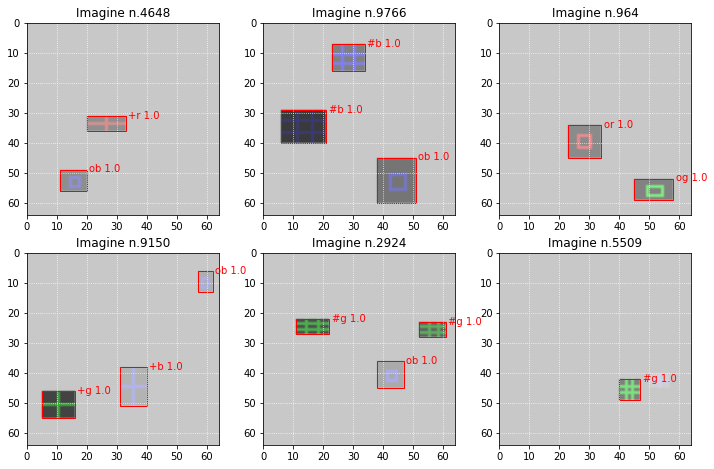

In [ ]:
# We take a look at some random images of our dataset and the relative bounding boxes 
n_visual = 6
rand_example = np.zeros((n_visual,), dtype=int)

fig = plt.figure(figsize=(12, 12))
for i in range(n_visual):
    # We take a random image of our training set
    rand_example[i] = np.random.randint(n_imgs)

    # We visualize it
    ax = fig.add_subplot((n_visual // 3) + 1, 3, i + 1)
    ax.grid( which='both', color='w', linestyle=':')
    plt.xticks(np.arange(0, side_dim, step=10))

    ax.set_title('Imagine n.' + str(rand_example[i]))
    visualize_preprocess(ax,
                          imgs[rand_example[i]],
                          None,
                          bounding_boxes[rand_example[i]],
                          Pc_th)
plt.show()

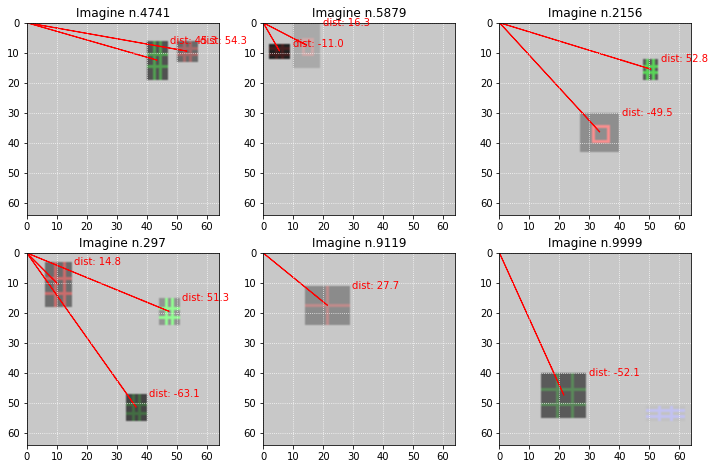

In [ ]:
# We look at the images again, this time highlighting the distance of the objects from the origin 
fig = plt.figure(figsize=(12,12))

for i in range(n_visual):
    # We visualize distance
    ax = fig.add_subplot((n_visual // 3) + 1, 3, i + 1)
    ax.grid( which='both', color='w', linestyle=':')
    plt.xticks(np.arange(0, side_dim, step=10))

    ax.set_title('Imagine n.' + str(rand_example[i]))
    visualize_preprocess(ax,
                          imgs[rand_example[i]],
                          distance[rand_example[i]],
                          bounding_boxes[rand_example[i]],
                          Pc_th) 
plt.show()

In [ ]:
# Look at an example for bounding boxes
example = 297
print('bounding boxes for image', example, 'are:')
print(bounding_boxes[example])

bounding boxes for image 297 are:
[[ 4.  1.  6.  3.  9. 15.]
 [ 5.  1. 33. 47.  7.  9.]
 [ 5.  1. 44. 15.  7.  9.]]


In [ ]:
# bounding boxes sorting based on distance from the origin
def order_bb(bounding_boxes, distance):   
    '''
    Arguments:
    bounding_boxes -- np.array(N_imgs, N_bb, 6), bounding boxes for each image
    distance -- np.array(N_imgs, N_bb), distance from origin for each Bounding box
    Returns:
    bboxes -- np.array(N_imgs, N_bb, 5), bounding boxes ordered
    '''

    n_imgs = bounding_boxes.shape[0]
    n_bb = bounding_boxes.shape[1]

    order = np.zeros((n_imgs, n_bb), dtype=int)
    bboxes = np.zeros(bounding_boxes.shape)

    for i in range(n_imgs):
        order[i] = np.argsort(distance[i])
        for j in range(n_bb):
            bboxes[i, j] = (bounding_boxes[i, order[i, j]])

    return bboxes

In [ ]:
# sorting based on distance from the origin
bb_ordered = order_bb(bounding_boxes, distance) 
obj_classes = bb_ordered[:,:,0]
obj_confidances = bb_ordered[:,:,1]

In [ ]:
# Look again at example bounding boxes
print('bounding boxes for image', example, 'are:')
print(bb_ordered[example])

bounding boxes for image 297 are:
[[ 5.  1. 33. 47.  7.  9.]
 [ 4.  1.  6.  3.  9. 15.]
 [ 5.  1. 44. 15.  7.  9.]]


In [ ]:
# now we consider classes and confidances of ours objects
obj_classes = bb_ordered[:,:,0]
obj_confidances = bb_ordered[:,:,1]
obj_classes.shape, obj_confidances.shape

((10000, 3), (10000, 3))

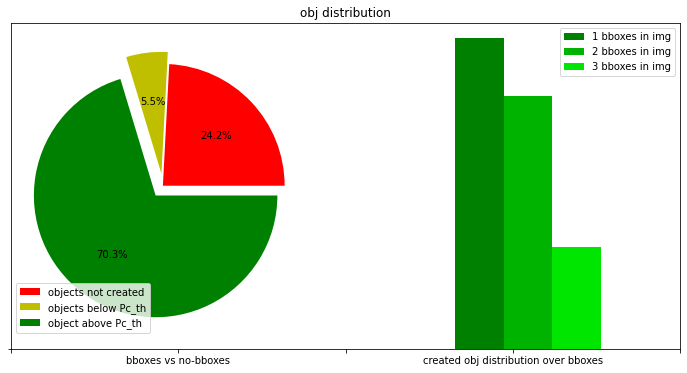

In [ ]:
# Plot Histogram with obj confidance distribution
fig = plt.figure(figsize=(12,6))
plt.gca().set(title='obj distribution')
plt.xticks([0,1,2,3,4], ['','bboxes vs no-bboxes', '','created obj distribution over bboxes',''])
plt.yticks([0], [''])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# pie with objects above_pc_obj, below_pc_obj and no_obj
explode = [0, .1, .1]
ax1.pie([no_obj, below_pc_obj, above_pc_obj], 
        autopct='%1.1f%%', explode=explode, colors=['r','y','g'])
ax1.legend(['objects not created','objects below Pc_th','object above Pc_th'])

# histogram with distribution obj over bounding boxes
ax2.hist(x=obj_confidances, bins=[.8, 1.1], color=[[.0, .5, .0], [.0, .7, .0], [.0, .9, .0]])
ax2.legend(['1 bboxes in img','2 bboxes in img','3 bboxes in img'])
ax2.set_xlim(.7, 1.2)
ax2.axis('off')

plt.show()

## Machine learning preprocessing

In [ ]:
# we compute images mean and image standar deviation
imgs_mean = np.mean(imgs)
imgs_std = np.std(imgs)

In [ ]:
# We normalize our images 
X = imgs - imgs_mean  # centering
X /= imgs_std         # scaling
print('X shape: ', X.shape, '---- Average value: ', imgs_mean, '---- Standard deviation:', np.std(imgs))

X shape:  (10000, 64, 64, 3) ---- Average value:  196.27745224609376 ---- Standard deviation: 18.370533082348363


In [ ]:
# we reshape target value
Y = bb_ordered.reshape(n_imgs, -1) 
print('Y shape: ',Y.shape)

Y shape:  (10000, 18)


In [ ]:
print('Images example', i, 'has shape:\n', X[example].shape, '\n')
print('...and the target values Y are:\n', Y[example])

Images example 5 has shape:
 (64, 64, 3) 

...and the target values Y are:
 [ 5.  1. 33. 47.  7.  9.  4.  1.  6.  3.  9. 15.  5.  1. 44. 15.  7.  9.]


In [ ]:
# split data into training, validation, and test sets (70%, 15%, 15%)

i_val = int(0.7 * n_imgs)
i_test = int(0.85 * n_imgs)

X_train = X[:i_val]
Y_train = Y[:i_val]

X_val = X[i_val:i_test]
Y_val = Y[i_val:i_test]

X_test = X[i_test:]
Y_test = Y[i_test:]

print('Below the dimensions of X and Y for Training set and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set and Test set respectively

(7000, 64, 64, 3) (7000, 18) (1500, 64, 64, 3) (1500, 18)
